# test lseg's ability to detect wall/room
- form vlmap, index with 'room'/'bedroom'/'livingroom'/'kitchen'/'bathroom'/'corridor'/'balcony'/'other'
- directly index image, then

In [3]:
import matplotlib.pyplot as plt
import cv2
def draw_hist(pc):
    # 绘制直方图
    plt.hist(pc, bins=30, alpha=0.75, color='blue', edgecolor='black')

    # 添加标题和标签
    plt.title('Data Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')

    # 显示图像
    plt.show()
def display_image_in_notebook(image_path):
    # 读取图像
    image = cv2.imread(image_path)
    
    # 检查图像是否成功读取
    if image is None:
        print(f"Failed to load image from {image_path}")
        return
    
    # 将图像从 BGR 转换为 RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 在 Jupyter Notebook 中显示图像
    plt.imshow(image_rgb)
    plt.axis('off')  # 关闭坐标轴
    plt.show()

In [ ]:

map_path = '/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1/vlmap_cam/vlmaps_cam.h5df'
import matplotlib.pyplot as plt

import numpy as np
mask = np.load('scored_list.npy')


In [28]:
min_height = 0
max_height = 1.7775
# mask >=min_height and mask < max_height and mask == inf 的为obstacle
depth_mask = (mask >= min_height) & (mask < max_height)

# visualize depth_mask using cv2
import cv2

def plot_2d_bool(depth_mask):
    # 将布尔掩码转换为uint8类型
    depth_mask_uint8 = depth_mask.astype(np.uint8) * 255

    # 创建伪彩色图像
    depth_colormap = cv2.applyColorMap(depth_mask_uint8, cv2.COLORMAP_JET)

    # 显示图像
    plt.figure(figsize=(10,8))
    plt.imshow(cv2.cvtColor(depth_colormap, cv2.COLOR_BGR2RGB))
    plt.colorbar()
    plt.title('深度图可视化')
    plt.show()


In [ ]:
import os

def get_surrounding_free_map(self, robot_pos, robot_height=1.05+0.8, update_camera_pose=False, verbose=True):
        # Define height range for free map
        # free_map: 1 for free space, 0 for occupied space

        min_height = 0
        max_height = self.isaac_camera.get_world_pose()-robot_height
        normal_threshold = 0.005

        # rgb_init, depth_init, mask, (row_min, row_max), (col_min, col_max), pointcloud = self._get_topdown_map(self.topdown_camera)

        # get info
        data_info = self.get_camera_data()
        rgb = np.array(data_info["rgba"])
        depth = np.array(data_info["depth"])

        # Generate mask for depth within the acceptable range
        depth_mask = (depth >= min_height) & (depth < max_height)

        # robot_mask
        robot_mask = self.create_robot_mask()

        # Combine masks to determine free space
        free_map = np.zeros_like(depth, dtype=int)
        free_map[depth_mask] = 1  # Free space is where conditions are met
        free_map[robot_mask == 1] = 1  # Robot's location is free space

        if verbose:
            img = Image.fromarray(rgb)
            if os.path.exists(self.args.log_image_dir+"/cam_free") == False:
                os.makedirs(self.args.log_image_dir+"/cam_free")
            img_path = os.path.join(self.args.log_image_dir, "cam_free","rgb_scene_local.png")
            img.save(img_path)
            # print("Image saved at", img_path)

            depth_img = self.vis_depth(depth, robot_height)
            depth_img_path = os.path.join(self.args.log_image_dir, "cam_free", "depth_scene_local.png")
            depth_img.save(depth_img_path)
            # print("Depth saved at", depth_img_path)
        
            # Visualize the free map
            free_map_normalized = free_map.astype(bool)
            # free_map_normalized = ((free_map - free_map.min()) * (1/(free_map.max() - free_map.min()) * 255)).astype('uint8')
            free_map_image = Image.fromarray(free_map_normalized)
            # Save the image
            free_map_path = os.path.join(self.args.log_image_dir, "cam_free", "topdown_local_freemap.png")
            free_map_image.save(free_map_path)
            # print("Free map saved at", free_map_path)
        
        # extract connectd free area
        connected_free_area = self.extract_connected_free_area(free_map, verbose=verbose)

        if update_camera_pose:
            # update the pose of the camera based on robot's pose
            self.issac_camera.set_world_pose([robot_pos[0], robot_pos[1], robot_pos[2]+0.8])

        return free_map, connected_free_area


In [1]:
from pathlib import Path
import hydra
from omegaconf import DictConfig
import sys, os
print(sys.path)

from vlmaps.application_my.room_test import TMP
from vlmaps.vlmaps.utils.matterport3d_categories import mp3dcat
from vlmaps.vlmaps.utils.visualize_utils import (
    pool_3d_label_to_2d,
    pool_3d_rgb_to_2d,
    visualize_rgb_map_3d,
    visualize_masked_map_2d,
    visualize_heatmap_2d,
    visualize_heatmap_3d,
    visualize_masked_map_3d,
    get_heatmap_from_mask_2d,
    get_heatmap_from_mask_3d,
)

import types
import numpy as np

# 原始字典
map_config = {
    'map_type': 'IsaacSimMap',
    'pose_info': {
        'pose_type': 'camera_base',
        'rot_type': 'quat',
        'camera_height': 1.5,
        'base2cam_rot': [1, 0, 0, 0, -1, 0, 0, 0, -1],
        'base_forward_axis': [0, 0, -1],
        'base_left_axis': [-1, 0, 0],
        'base_up_axis': [0, 1, 0]
    },
    'model': {  # 添加model配置
        'threshold': 0.3,  # 设置阈值
    },
    'skip_frame': 1,
    'cam_calib_mat': [221, 0, 128, 0, 221, 128, 0, 0, 1],
    'grid_size': '${params.gs}',
    'cell_size': '${params.cs}',
    'robot_z': '${params.robot_z}',
    'depth_sample_rate': 50,
    'dilate_iter': 3,
    'gaussian_sigma': 1.0,
    'customize_obstacle_map': False,
    'potential_obstacle_names': ['wall', 'floor', 'chair', 'door', 'table', 'picture', 'cabinet', 'cushion', 'window', 'sofa', 'bed', 'curtain', 'chest_of_drawers', 'plant', 'sink', 'stairs', 'ceiling', 'toilet', 'stool', 'towel', 'mirror', 'tv_monitor', 'shower', 'column', 'bathtub', 'counter', 'fireplace', 'lighting', 'beam', 'railing', 'shelving', 'blinds', 'gym_equipment', 'seating', 'board_panel', 'furniture', 'appliances', 'clothes', 'objects'],
    'obstacle_names': ['wall', 'floor', 'chair', 'door', 'table', 'picture', 'cabinet', 'cushion', 'window', 'sofa', 'bed', 'curtain', 'chest_of_drawers', 'plant', 'sink', 'stairs', 'ceiling', 'toilet', 'stool', 'towel', 'mirror', 'tv_monitor', 'shower', 'column', 'bathtub', 'counter', 'fireplace', 'lighting', 'beam', 'railing', 'shelving', 'blinds', 'gym_equipment', 'seating', 'board_panel', 'furniture', 'appliances', 'clothes', 'objects'],
    'categories': 'mp3d',
    
}

# 将字典转换为 SimpleNamespace 对象
map_config_ns = types.SimpleNamespace(**map_config)
map_config_ns.pose_info = types.SimpleNamespace(**map_config_ns.pose_info)

# 示例使用
self = types.SimpleNamespace()
self.map_config = map_config_ns
self.base2cam_tf = np.zeros((3, 3))  # 假设 self.base2cam_tf 是一个 3x3 的矩阵

# 访问并设置属性
self.base2cam_tf[:3, :3] = np.array(self.map_config.pose_info.base2cam_rot).reshape((3, 3))

# vlmap_save_path =  '/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7_1/'
# vlmap_save_path = '/ssd/xiaxinyuan/code/w61-grutopia/logs_docker/7y3sRwLe3Va/id_7/'
# vlmap_save_path = '/ssd/xiaxinyuan/code/w61-grutopia/logs_docker/mJXqzFtmKg4/id_32/'
# vlmap_save_path ='/ssd/xiaxinyuan/code/w61-grutopia/logs/5LpN3gDmAk7/id_5/'
vlmap_save_path = '/ssd/xiaxinyuan/code/w61-grutopia/logs/sample_episodes/s8pcmisQ38h/id_37/'
vlmap = TMP(self.map_config, data_dir= vlmap_save_path)
vlmap._init_clip()


['/home/xiaxinyuan/.conda/envs/isaacsim/lib/python310.zip', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/lib-dynload', '', '/home/xiaxinyuan/.local/lib/python3.10/site-packages', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages', '__editable__.omni_isaac_lab-0.22.1.finder.__path_hook__', '__editable__.omni_isaac_lab_assets-0.1.3.finder.__path_hook__', '__editable__.omni_isaac_lab_tasks-0.10.0.finder.__path_hook__', '/ssd/xiaxinyuan/code/w61-grutopia', '/home/xiaxinyuan/Hierarchical-Localization', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10/site-packages/setuptools/_vendor']
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
['/home/xiaxinyuan/.conda/envs/isaacsim/lib/python310.zip', '/home/xiaxinyuan/.conda/envs/isaacsim/lib/python3.10', '/home/xiaxinyuan/.conda/envs/isaacsim/l

[array([0.23920813], dtype=float32), array([0.25955206], dtype=float32), array([0.2542847], dtype=float32), array([0.24458659], dtype=float32), array([0.22963493], dtype=float32), array([0.24123302], dtype=float32), array([0.2003429], dtype=float32)]
gt_name: living_room, pred_name: dining room


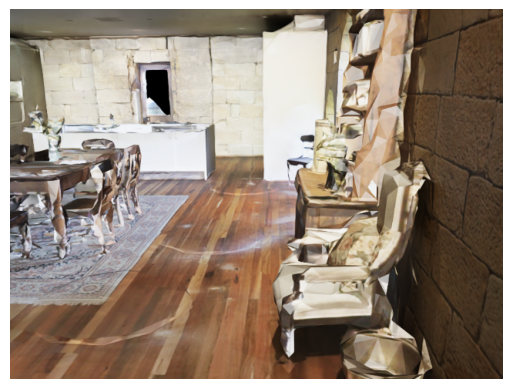

[array([0.2629793], dtype=float32), array([0.2788759], dtype=float32), array([0.256802], dtype=float32), array([0.27667025], dtype=float32), array([0.2525734], dtype=float32), array([0.23249303], dtype=float32), array([0.21017201], dtype=float32)]
gt_name: living_room, pred_name: dining room


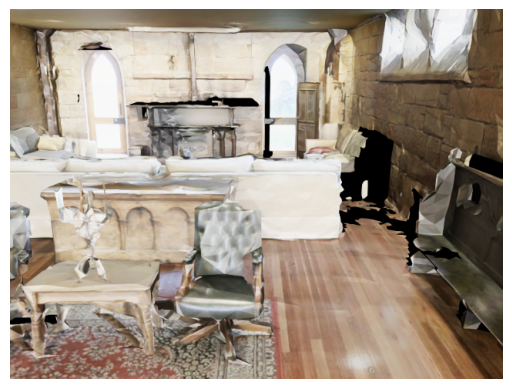

[array([0.23182818], dtype=float32), array([0.24302022], dtype=float32), array([0.22368987], dtype=float32), array([0.2502051], dtype=float32), array([0.23827995], dtype=float32), array([0.22802113], dtype=float32), array([0.20833723], dtype=float32)]
gt_name: living_room, pred_name: living room


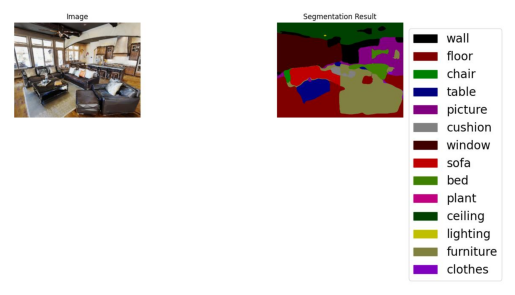

[array([0.19500515], dtype=float32), array([0.18677631], dtype=float32), array([0.18460625], dtype=float32), array([0.19884488], dtype=float32), array([0.20108995], dtype=float32), array([0.19433346], dtype=float32), array([0.20640303], dtype=float32)]
gt_name: dining_room, pred_name: unknown


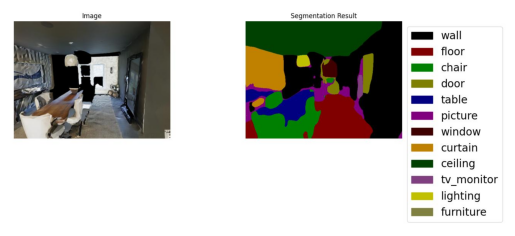

[array([0.19990681], dtype=float32), array([0.19841073], dtype=float32), array([0.20103616], dtype=float32), array([0.19854352], dtype=float32), array([0.20172305], dtype=float32), array([0.20064336], dtype=float32), array([0.21784863], dtype=float32)]
gt_name: toilet, pred_name: unknown


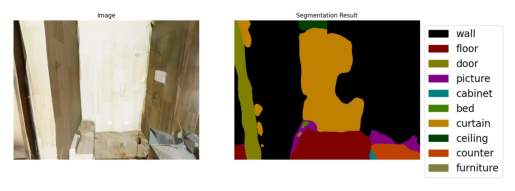

[array([0.20521344], dtype=float32), array([0.20059685], dtype=float32), array([0.22278239], dtype=float32), array([0.19188237], dtype=float32), array([0.20407756], dtype=float32), array([0.2174619], dtype=float32), array([0.20320514], dtype=float32)]
gt_name: toilet, pred_name: kitchen


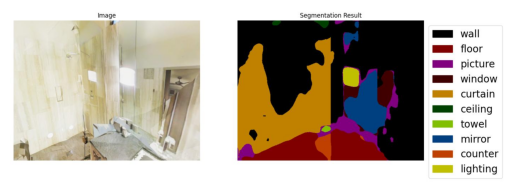

[array([0.22795224], dtype=float32), array([0.19845504], dtype=float32), array([0.2021612], dtype=float32), array([0.2057775], dtype=float32), array([0.20589954], dtype=float32), array([0.21985199], dtype=float32), array([0.20110916], dtype=float32)]
gt_name: toilet, pred_name: bedroom


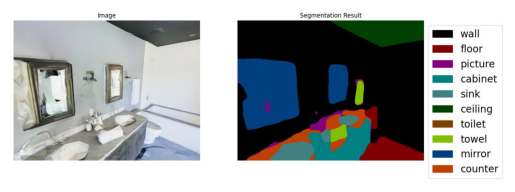

[array([0.19692153], dtype=float32), array([0.19643083], dtype=float32), array([0.19710357], dtype=float32), array([0.1913209], dtype=float32), array([0.19669165], dtype=float32), array([0.19185977], dtype=float32), array([0.21119492], dtype=float32)]
gt_name: bedroom, pred_name: unknown


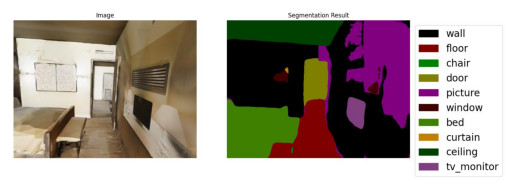

[array([0.2150253], dtype=float32), array([0.21412057], dtype=float32), array([0.20750892], dtype=float32), array([0.21819106], dtype=float32), array([0.21134634], dtype=float32), array([0.21997607], dtype=float32), array([0.20849055], dtype=float32)]
gt_name: bedroom, pred_name: hallway


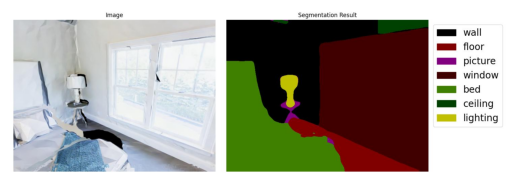

[array([0.21180394], dtype=float32), array([0.20609114], dtype=float32), array([0.2238536], dtype=float32), array([0.19893517], dtype=float32), array([0.21675323], dtype=float32), array([0.23704267], dtype=float32), array([0.2186843], dtype=float32)]
gt_name: hallway, pred_name: hallway


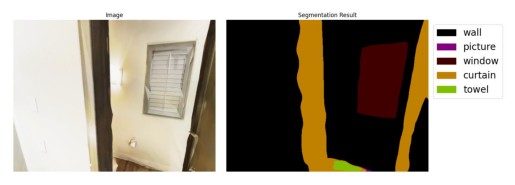

[array([0.2082221], dtype=float32), array([0.20426507], dtype=float32), array([0.202374], dtype=float32), array([0.20909715], dtype=float32), array([0.19569908], dtype=float32), array([0.21419571], dtype=float32), array([0.2156707], dtype=float32)]
gt_name: hallway, pred_name: unknown


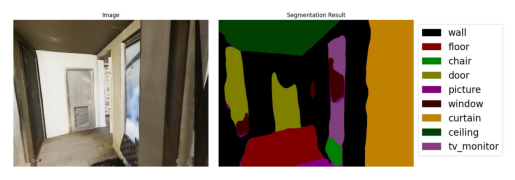

[array([0.215997], dtype=float32), array([0.21225885], dtype=float32), array([0.22031315], dtype=float32), array([0.21598208], dtype=float32), array([0.21155235], dtype=float32), array([0.2289885], dtype=float32), array([0.21684097], dtype=float32)]
gt_name: hallway, pred_name: hallway


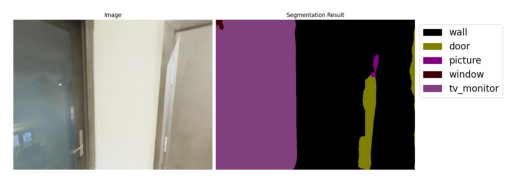

[array([0.19509934], dtype=float32), array([0.18586038], dtype=float32), array([0.18977125], dtype=float32), array([0.19074926], dtype=float32), array([0.19718395], dtype=float32), array([0.2020063], dtype=float32), array([0.20484416], dtype=float32)]
gt_name: hallway, pred_name: unknown


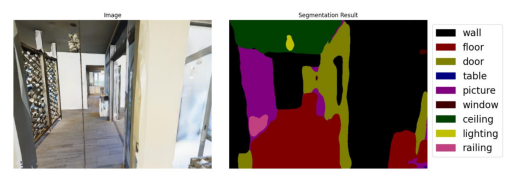

[array([0.19098619], dtype=float32), array([0.19671327], dtype=float32), array([0.19267939], dtype=float32), array([0.19237292], dtype=float32), array([0.19045818], dtype=float32), array([0.2200456], dtype=float32), array([0.19817343], dtype=float32)]
gt_name: hallway, pred_name: hallway


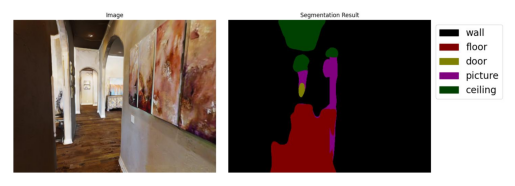

[array([0.19233268], dtype=float32), array([0.18329726], dtype=float32), array([0.18620917], dtype=float32), array([0.19252966], dtype=float32), array([0.20377994], dtype=float32), array([0.19206549], dtype=float32), array([0.21984294], dtype=float32)]
gt_name: kitchen, pred_name: unknown


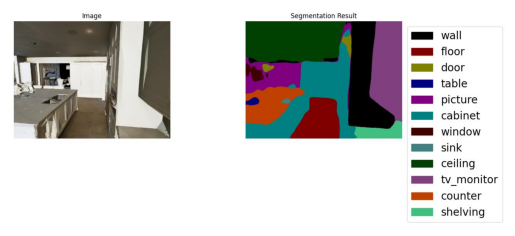

[array([0.22377354], dtype=float32), array([0.21957901], dtype=float32), array([0.21157812], dtype=float32), array([0.23006594], dtype=float32), array([0.2040629], dtype=float32), array([0.23454198], dtype=float32), array([0.19395006], dtype=float32)]
gt_name: kitchen, pred_name: hallway


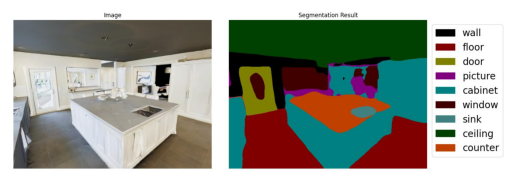

[array([0.1783016], dtype=float32), array([0.1851847], dtype=float32), array([0.18237063], dtype=float32), array([0.18596491], dtype=float32), array([0.19238792], dtype=float32), array([0.19740404], dtype=float32), array([0.19312434], dtype=float32)]
gt_name: kitchen, pred_name: hallway


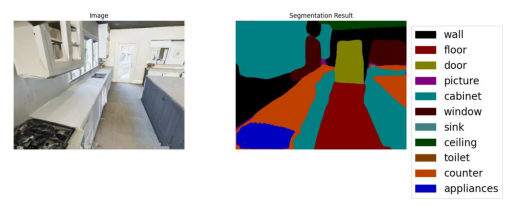

[array([0.22948113], dtype=float32), array([0.23633271], dtype=float32), array([0.22901632], dtype=float32), array([0.22988677], dtype=float32), array([0.23469687], dtype=float32), array([0.23305152], dtype=float32), array([0.22538705], dtype=float32)]
gt_name: others, pred_name: dining room


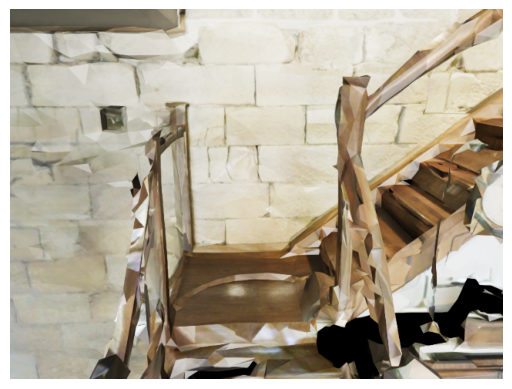

[array([0.2111369], dtype=float32), array([0.21214664], dtype=float32), array([0.23080222], dtype=float32), array([0.19377111], dtype=float32), array([0.21848035], dtype=float32), array([0.23913005], dtype=float32), array([0.22116572], dtype=float32)]
gt_name: others, pred_name: hallway


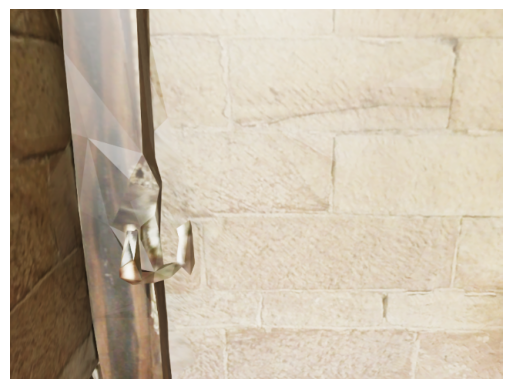

[array([0.19995545], dtype=float32), array([0.19179963], dtype=float32), array([0.20087123], dtype=float32), array([0.18084192], dtype=float32), array([0.20064577], dtype=float32), array([0.21847421], dtype=float32), array([0.22345687], dtype=float32)]
gt_name: others, pred_name: unknown


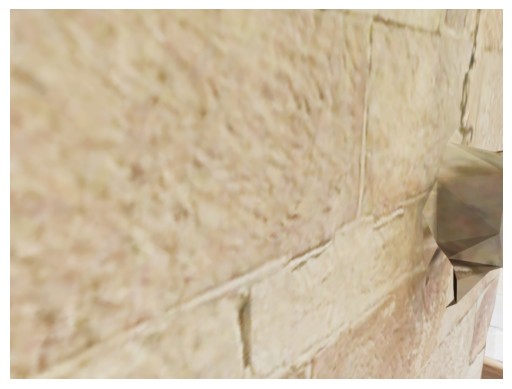

[array([0.24194592], dtype=float32), array([0.25830325], dtype=float32), array([0.26120394], dtype=float32), array([0.24318993], dtype=float32), array([0.2308401], dtype=float32), array([0.22405542], dtype=float32), array([0.21335326], dtype=float32)]
gt_name: others, pred_name: kitchen


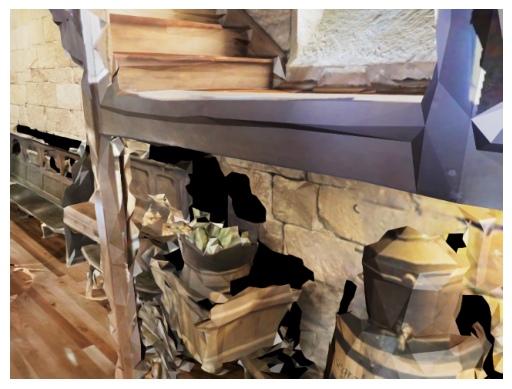

In [4]:
import cv2
living_room_path_list = [
    "logs/sample_episodes_safe/s8pcmisQ38h/id_2606/rgb/pano_camera_0_image_step_26.png",
    "logs/sample_episodes_safe/s8pcmisQ38h/id_37/rgb/pano_camera_0_image_step_299.png",
    "logs_docker/8WUmhLawc2A/id_68/segmentation/9400.jpg"
]
dining_room_path_list = [
    "logs_docker/7y3sRwLe3Va/id_1/segmentation/5600.jpg",
]
toilet_path_list = [
    "logs/sT4fr6TAbpF/id_13/segmentation/200.jpg",
    "logs/sT4fr6TAbpF/id_13/segmentation/400.jpg",
    "logs_docker/7y3sRwLe3Va/id_7/segmentation/19000.jpg"
]
bedroom_path_list = [
    "logs/sT4fr6TAbpF/id_13/segmentation/3000.jpg",
    "logs_docker/7y3sRwLe3Va/id_7/segmentation/600.jpg",

]
hallway_path_list = [
    "logs/sT4fr6TAbpF/id_13/segmentation/1000.jpg",
    "logs/sT4fr6TAbpF/id_13/segmentation/4000.jpg",
    "logs/sT4fr6TAbpF/id_13/segmentation/6200.jpg",
    "logs/sT4fr6TAbpF/id_13/segmentation/9000.jpg",
    "logs_docker/8WUmhLawc2A/id_68/segmentation/3600.jpg"
]
kitchen_path_list = [
    "logs_docker/7y3sRwLe3Va/id_1/segmentation/1000.jpg",
    "logs_docker/7y3sRwLe3Va/id_1/segmentation/1600.jpg",
    "logs_docker/7y3sRwLe3Va/id_1/segmentation/3600.jpg"

]    
others_path_list = [
    "logs/sample_episodes_safe/s8pcmisQ38h/id_2606/rgb/pano_camera_0_image_step_35.png",
    "logs/sample_episodes_safe/s8pcmisQ38h/id_37/rgb/pano_camera_0_image_step_254.png",
    "logs/sample_episodes_safe/s8pcmisQ38h/id_37/rgb/pano_camera_0_image_step_263.png",
    "logs/sample_episodes_safe/s8pcmisQ38h/id_37/rgb/pano_camera_0_image_step_281.png"
]

list_all = [living_room_path_list,dining_room_path_list,toilet_path_list,bedroom_path_list,hallway_path_list,kitchen_path_list,others_path_list]

room_names = ['living_room','dining_room','toilet','bedroom','hallway','kitchen','others']
def get_room(path_list,gt_name):
    for path in path_list:
        image = cv2.imread(path)
    
        room = vlmap.judge_room(image)
        print(f"gt_name: {gt_name}, pred_name: {room}")
        display_image_in_notebook(path)
    
try:
    for gt_name,path_list in zip(room_names,list_all):
        get_room(path_list,gt_name)
except Exception as e:
    print(e)



In [ ]:
# room level segmentation



## object segmentation

In [23]:
import cv2
import matplotlib.pyplot as plt


vlmap.load_map(vlmap_save_path)
vlmap._init_clip()
cat = 'kitchen'
gs =200
cs = 0.1
decay_rate = 0.02


clip model is already initialized


In [19]:
def visualize_2d(cat,mask):
    # init categories with cat and other:
    mask = vlmap.index_map(cat, with_init_cat=False,threshold=0)
    mask_2d = pool_3d_label_to_2d(mask, vlmap.grid_pos, gs)
    rgb_2d = pool_3d_rgb_to_2d(vlmap.grid_rgb, vlmap.grid_pos, gs)

    print(vlmap.map_save_path)

    save_path = Path(vlmap_save_path) /'vlmap_cam'/ f"{cat}_masked_2d_binary.jpg"
    visualize_masked_map_2d(rgb_2d, mask_2d, save_path = save_path)
    display_image_in_notebook(save_path)

    heatmap = get_heatmap_from_mask_2d(mask_2d, cell_size=cs, decay_rate=decay_rate)
    save_path = Path(vlmap_save_path)/'vlmap_cam'/ f"{cat}_heatmap_2d_binary.jpg"
    visualize_heatmap_2d(rgb_2d, heatmap,save_path=save_path)
    display_image_in_notebook(save_path)

def visualize_3d(cat, mask):
    save_path = f'{vlmap_save_path}/vlmap_cam/{cat}_masked_3d_binary.pcd'
    visualize_masked_map_3d(vlmap.grid_pos, mask, vlmap.grid_rgb, save_path = save_path)
    heatmap = get_heatmap_from_mask_3d(
            vlmap.grid_pos, mask, cell_size=cs, decay_rate=decay_rate
        )
    save_path = f'{vlmap_save_path}/vlmap_cam/{cat}_heatmap_3d_binary.pcd'
    visualize_heatmap_3d(vlmap.grid_pos, heatmap, vlmap.grid_rgb, save_path = save_path)


In [26]:
vlmap.grid_pos.shape

(17579, 3)

In [25]:
vlmap.scores_mat
draw_hist(vlmap.scores_mat[1])


NameError: name 'draw_hist' is not defined

In [34]:
np.sum(mask)

35

wall,floor,chair,door,table,picture,cabinet,cushion,window,sofa,bed,curtain,chest_of_drawers,plant,sink,stairs,ceiling,toilet,stool,towel,mirror,tv_monitor,shower,column,bathtub,counter,fireplace,lighting,beam,railing,shelving,blinds,gym_equipment,seating,board_panel,furniture,appliances,clothes
sofa
Image saved to tmp/living_room_masked_2d.jpg


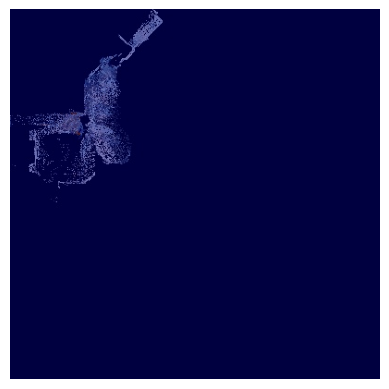

Image saved to tmp/living_room_heatmap_2d.jpg


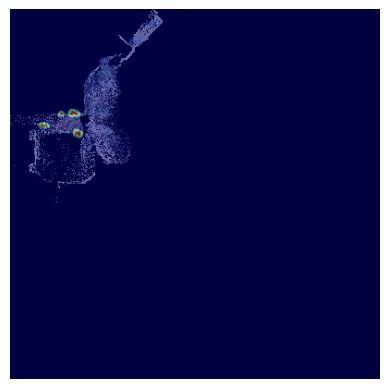

In [33]:
cat = 'living_room'
vlmap.init_categories(mp3dcat[1:-1])
mask = vlmap.index_map(cat, with_init_cat=True)

mask_2d = pool_3d_label_to_2d(mask, vlmap.grid_pos, gs*2)
rgb_2d = pool_3d_rgb_to_2d(vlmap.grid_rgb, vlmap.grid_pos, gs*2)
save_path = 'tmp/' + f"{cat}_masked_2d.jpg"
visualize_masked_map_2d(rgb_2d, mask_2d,save_path=save_path)
display_image_in_notebook(save_path)


heatmap = get_heatmap_from_mask_2d(mask_2d, cell_size=cs, decay_rate=decay_rate)
save_path = 'tmp/' +  f"{cat}_heatmap_2d.jpg"
visualize_heatmap_2d(rgb_2d, heatmap,save_path=save_path)
display_image_in_notebook(save_path)


In [15]:
a = [1,2,3]
b = [1,2]

a.append(b)
print(a)

[1, 2, 3, [1, 2]]


In [42]:

max_idx = np.argmax(vlmap.scores_mat, axis=1)
topdown_mask = np.zeros([200,200]).astype(int)
for pos,lbl in zip(vlmap.grid_pos,max_idx):
   topdown_mask[pos[0],pos[1]] = int(lbl+1)



from vlmaps.vlmaps.utils.mapping_utils import get_new_mask_pallete,get_new_pallete
# labels: ['null', other labels in mp3d]

labels = mp3dcat


In [44]:

new_palette = get_new_pallete(len(labels))
mask, patches = get_new_mask_pallete(topdown_mask, new_palette, out_label_flag=True, labels=labels)
seg = mask.convert("RGBA")

# 创建图像和分割结果的子图
fig, ax = plt.subplots(figsize=(15, 10))
ax.imshow(seg)
ax.set_title("Segmentation Result")
ax.axis("off")

# 创建图例
legend_fig, legend_ax = plt.subplots(figsize=(15, 2))
legend_ax.legend(handles=patches, loc="center", ncol=10, prop={"size": 10})
legend_ax.axis("off")

# 保存图像和图例
plt.tight_layout()
fig.savefig('segmentation_result.jpg', bbox_inches='tight')
legend_fig.savefig('segmentation_legend.jpg', bbox_inches='tight')

# 关闭图形以释放内存
plt.close(fig)
plt.close(legend_fig)

<BarContainer object of 10 artists>

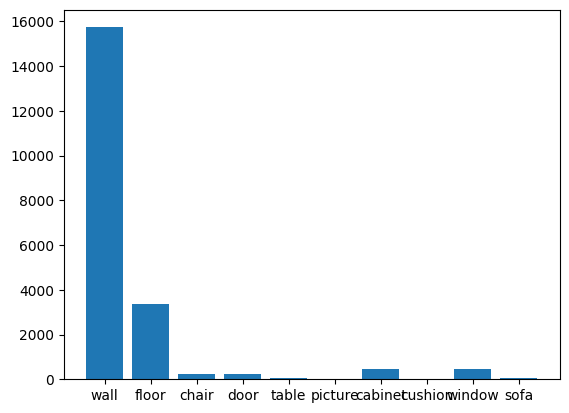

In [15]:

max_values = np.max(mask, axis=1)

# 计算每一行最大值对应的索引
max_indices = np.argmax(mask, axis=1)

# draw_hist(max_values)

from vlmaps.vlmaps.utils.matterport3d_categories import mp3dcat
indexed_dict = mp3dcat[1:]

sum_of_idx = np.zeros(len(indexed_dict))
for i in max_indices:
    sum_of_idx[i] += 1

plt.bar(indexed_dict[:10], sum_of_idx[:10])


<BarContainer object of 10 artists>

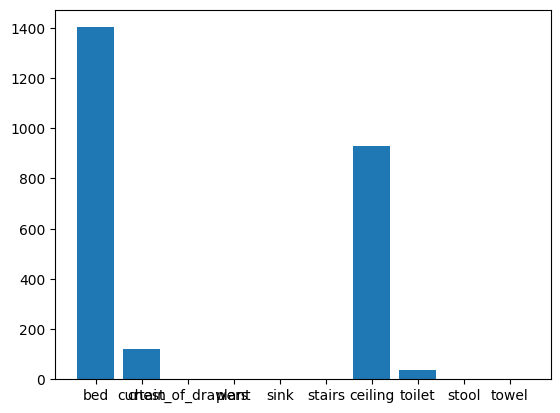

In [16]:


plt.bar(indexed_dict[10:20], sum_of_idx[10:20])


['mirror', 'tv_monitor', 'shower', 'column', 'bathtub', 'counter', 'fireplace', 'lighting', 'beam', 'railing', 'shelving', 'blinds', 'gym_equipment', 'seating', 'board_panel', 'furniture', 'appliances', 'clothes', 'objects']


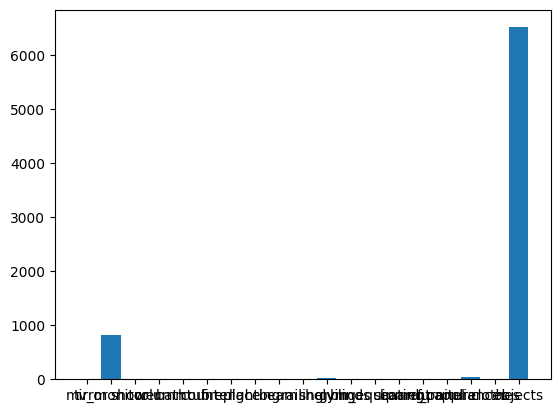

In [18]:


plt.bar(indexed_dict[20:], sum_of_idx[20:])
print(indexed_dict[20:])



# Instruction Tuning

In [ ]:
from vlmaps.vlmaps.utils.llm_utils import parse_spatial_instruction

import os
import json
def read_instructions_from_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
    print(f"Instructions read from {file_path}")
    return data

# 使用示例
file_path = 'tmp/instructions.json'
instructions = read_instructions_from_file(file_path)

parse_spatial_instruction(instructions[0]['instruction'])
# # 通过索引访问数据
# for instruction in instructions:
#     print(f"Idx: {instruction['idx']}, Instruction: {instruction['instruction']}")


In [4]:
from vlmaps.vlmaps.utils.index_utils import find_similar_category_id
from vlmaps.vlmaps.utils.matterport3d_categories import mp3dcat
find_similar_category_id('kitchen', mp3dcat)


void,wall,floor,chair,door,table,picture,cabinet,cushion,window,sofa,bed,curtain,chest_of_drawers,plant,sink,stairs,ceiling,toilet,stool,towel,mirror,tv_monitor,shower,column,bathtub,counter,fireplace,lighting,beam,railing,shelving,blinds,gym_equipment,seating,board_panel,furniture,appliances,clothes,objects
cabinet


7

In [ ]:
import gzip
import json
import copy
import os
starrt_pos_dict = {}
instruction_list = []
def load_data(split):
    ''' Load data based on VLN-CE
    '''
    # dataset_root_dir = base_data_dir # '../VLN/VLNCE/R2R_VLNCE_v1-3'
    dataset_root_dir = '/ssd/xiaxinyuan/code/VLN/VLNCE/R2R_VLNCE_v1-3'
    total_scans = []
    load_data = []
    with gzip.open(os.path.join(dataset_root_dir, f"{split}", f"{split}.json.gz"), 'rt', encoding='utf-8') as f:
        data = json.load(f)
        for item in data["episodes"]:
            
            name = os.path.splitext(os.path.basename(item['scene_id']))[0]
            start_position = item['instruction']['instruction_text']
            print(name,item['episode_id'], item['trajectory_id'],start_position)
            instruction_list.append({'idx':name,'instruction':start_position})
            # item["original_start_position"] = copy.copy(item["start_position"])
            # item["original_start_rotation"] = copy.copy(item["start_rotation"])
            # item["start_position"] = [item["original_start_position"][0], -item["original_start_position"][2], item["original_start_position"][1]]
            # item["start_rotation"] = [-item["original_start_rotation"][3], item["original_start_rotation"][0], item["original_start_rotation"][2], -item["original_start_rotation"][1]] # [x,y,z,-w] => [w,x,y,z]
            # item["scan"] = item["scene_id"].split("/")[1]
            # item["c_reference_path"] = []
            # if "reference_path" in item.keys():
            #     for path in item["reference_path"]:
            #         item["c_reference_path"].append([path[0], -path[2], path[1]])
            #     item["reference_path"] = item["c_reference_path"]
            #     del item["c_reference_path"]
            # load_data.append(item)
            # total_scans.append(item["scan"])

    # return load_data, list(set(total_scans))

# splits = ['train', 'val_seen', 'val_unseen', 'test']
splits = ['train']
for split in splits:
    load_data(split)

# def save_dict_to_file(data, file_path):
#     with open(file_path, 'w', encoding='utf-8') as file:
#         json.dump(data, file, ensure_ascii=False, indent=4)
#     print(f"Dictionary saved to {file_path}")
# file_path = 'tmp/instructions.json'
# save_dict_to_file(instruction_list, file_path)


In [3]:
import json
json_file = '/ssd/share/vlmap/vlmaps_dataset/5LpN3gDmAk7_1/spatial_goal_navigation_tasks.json'
with open(json_file, 'r', encoding='utf-8') as file:
    data = json.load(file)
    print(f"Instructions read from {json_file}")


Instructions read from /ssd/share/vlmap/vlmaps_dataset/5LpN3gDmAk7_1/spatial_goal_navigation_tasks.json


In [16]:
data[0]['instruction']


'move first to the left side of the counter in front of you, face the counter and then move to the west of the counter, later, with the counter on your right, go to the east of the chair in front of you, and finally move to the sofa in front of you.'

In [4]:
from vlmaps.vlmaps.utils.llm_utils import parse_spatial_instruction
parse_spatial_instruction(data[0]['instruction'])


"```python\nself.move_to_left('counter')\nself.face('counter')\nself.move_west('counter')\nself.with_object_on_right('counter')\nself.move_east('chair')\nself.move_to_object('sofa')\n```"

In [7]:
test_str = 'for i in range(10):\n print(i)'
exec(test_str)


0
1
2
3
4
5
6
7
8
9


In [8]:
import re

def extract_self_methods(input_string):
    """
    从输入字符串中提取以 `self.` 开头的所有部分，并放到一个列表中
    :param input_string: 输入字符串
    :return: 提取的部分列表
    """
    # 使用正则表达式匹配以 `self.` 开头的部分
    matches = re.findall(r'self\.\w+\(.*?\)', input_string)
    return matches

# 示例输入
input_string = "python\nself.move_to_left('counter')\nself.face('counter')\nself.move_west('counter')\nself.with_object_on_right('counter')\nself.move_east('chair')\nself.move_to_object('sofa')\n"

# 提取以 `self.` 开头的部分
extracted_methods = extract_self_methods(input_string)

# 打印结果
print(extracted_methods)


["self.move_to_left('counter')", "self.face('counter')", "self.move_west('counter')", "self.with_object_on_right('counter')", "self.move_east('chair')", "self.move_to_object('sofa')"]


In [ ]:
pcd_global = o3d.geometry.PointCloud()
pcd_global.points = o3d.utility.Vector3dVector(pc_filtered)
visualize_pc(pcd_global, headless = True)


In [ ]:
# get camera:
self.env._runner.current_tasks[self.task_name].robots[self.robot_name].sensors['pano_camera_0'].get_world_pose()
rgb = self.topdown_camera.get_data()["rgba"] # topdown_camera: grutopia_camera
cv2.imwrite('panp_rgb.jpg',rgb)

# get curr pos
self.issac_camera.get_world_pose()


# filter the threads
total num(without stairs): 'train':8158, 'val_seen': 559, 'val_unseen': 1284, 'test': 2364

ignore all episodes with 'stairs' in the instruction and separate them into multiple 
numpy arrays

write a function with input 

n: number of gpus to distribute the data

dataset_root_dir: the root directory of the dataset

first calculate by trajectory_id, then by episode_id


In [2]:
import gzip
import json
import copy
import os
starrt_pos_dict = {}
episode_id = []
def load_data(split):
    ''' Load data based on VLN-CE
    '''
    # dataset_root_dir = base_data_dir # '../VLN/VLNCE/R2R_VLNCE_v1-3'
    dataset_root_dir = '/ssd/xiaxinyuan/code/VLN/VLNCE/R2R_VLNCE_v1-3'
    instruction_list = []
    total_scans = []
    load_data = []
    with gzip.open(os.path.join(dataset_root_dir, f"{split}", f"{split}.json.gz"), 'rt', encoding='utf-8') as f:
        data = json.load(f)
        for item in data["episodes"]:
            if ('stairs' in item['instruction']['instruction_text']):
                continue
            name = os.path.splitext(os.path.basename(item['scene_id']))[0]
            # start_position = item['instruction']['instruction_text']
            start_position = item['start_position']
            print(name,item['episode_id'], item['trajectory_id'],start_position)
            instruction_list.append({'idx':name,'instruction':start_position})
            # item["original_start_position"] = copy.copy(item["start_position"])
            # item["original_start_rotation"] = copy.copy(item["start_rotation"])
            # item["start_position"] = [item["original_start_position"][0], -item["original_start_position"][2], item["original_start_position"][1]]
            # item["start_rotation"] = [-item["original_start_rotation"][3], item["original_start_rotation"][0], item["original_start_rotation"][2], -item["original_start_rotation"][1]] # [x,y,z,-w] => [w,x,y,z]
            # item["scan"] = item["scene_id"].split("/")[1]
            # item["c_reference_path"] = []
            # if "reference_path" in item.keys():
            #     for path in item["reference_path"]:
            #         item["c_reference_path"].append([path[0], -path[2], path[1]])
            #     item["reference_path"] = item["c_reference_path"]
            #     del item["c_reference_path"]
            # load_data.append(item)
            # total_scans.append(item["scan"])
    return instruction_list
    # return load_data, list(set(total_scans))

# splits = ['train', 'val_seen', 'val_unseen', 'test']
# splits = ['train']
splits = ['val_unseen']
for split in splits:
    instruction_list = load_data(split)
    print(len(instruction_list))
# def save_dict_to_file(data, file_path):
#     with open(file_path, 'w', encoding='utf-8') as file:
#         json.dump(data, file, ensure_ascii=False, indent=4)
#     print(f"Dictionary saved to {file_path}")
# file_path = 'tmp/instructions.json'
# save_dict_to_file(instruction_list, file_path)


E9uDoFAP3SH 4 93 [13.333499908447266, 0.24438095092773438, 5.276130199432373]
E9uDoFAP3SH 5 93 [13.333499908447266, 0.24438095092773438, 5.276130199432373]
E9uDoFAP3SH 6 93 [13.333499908447266, 0.24438095092773438, 5.276130199432373]
r1Q1Z4BcV1o 7 111 [-9.448829650878906, 0.07537198066711426, -0.8151869773864746]
r1Q1Z4BcV1o 9 111 [-9.448829650878906, 0.07537198066711426, -0.8151869773864746]
759xd9YjKW5 10 139 [-7.182509899139404, 0.09666500240564346, 21.212299346923828]
759xd9YjKW5 11 139 [-7.182509899139404, 0.09666500240564346, 21.212299346923828]
759xd9YjKW5 12 139 [-7.182509899139404, 0.09666500240564346, 21.212299346923828]
sT4fr6TAbpF 13 149 [-0.9836609959602356, 0.05631500482559204, 3.532670021057129]
sT4fr6TAbpF 14 149 [-0.9836609959602356, 0.05631500482559204, 3.532670021057129]
sT4fr6TAbpF 15 149 [-0.9836609959602356, 0.05631500482559204, 3.532670021057129]
JeFG25nYj2p 16 180 [-2.485460042953491, 0.09358400106430054, 4.0524702072143555]
JeFG25nYj2p 17 180 [-2.48546004295349

In [12]:
import gzip
import json
import copy
import os
starrt_pos_dict = {}
episode_id = []
trajectory_id_list = []

def get_sub_trajectory_id_list():
    with open('vlmaps/docker/valid_paths/unseen.txt', 'r') as f:
        sub_trajectory_id_list = [int(line.strip()) for line in f.readlines()]
        # 重新按大小排序
        sub_trajectory_id_list.sort()
    return sub_trajectory_id_list


def find_gpu_id(trajectory_id,num_of_gpus,trajectory_id_list):
    for idx, id in enumerate(trajectory_id_list):
        if (id == trajectory_id):
            return idx % num_of_gpus
def judge_stair_exists(path):
    '''
    path_z: ndarray, if max(path_z)- min(path_z) > 1.5, then there is a stair
    '''
    path_z = []
    for path in path:
        path_z.append(path[1])
    return max(path_z)- min(path_z) > 1.5

def load_data(split,num_of_gpus):
    ''' Load data based on VLN-CE
    '''
    # dataset_root_dir = base_data_dir # '../VLN/VLNCE/R2R_VLNCE_v1-3'
    dataset_root_dir = '/ssd/xiaxinyuan/code/VLN/VLNCE/R2R_VLNCE_v1-3'
    scene_id_list = []
    total_scans = []
    load_data = []
    split_data = [[] for _ in range(num_of_gpus)]
    trajectory_id_list = get_sub_trajectory_id_list()
    print(len(trajectory_id_list))
    for split in splits:
            with gzip.open(os.path.join(dataset_root_dir, f"{split}", f"{split}.json.gz"), 'rt', encoding='utf-8') as f:
                data = json.load(f)
            for item in data["episodes"]:
                scene_id = item['scene_id'].split('/')[1]
                if scene_id not in scene_id_list:
                    scene_id_list.append(scene_id)
            for item in data["episodes"]:
                if not judge_stair_exists(item['reference_path'])  and (item['trajectory_id'] in trajectory_id_list):
                    
                    scene_id = item['scene_id'].split('/')[1]
                    gpu_id = find_gpu_id(scene_id, num_of_gpus, scene_id_list)
                    split_data[gpu_id].append((scene_id,item['trajectory_id'],item['episode_id']))
                    print(scene_id,item['trajectory_id'],item['episode_id'])

    # sort the split_data by the scene_id
    for i in range(num_of_gpus):
        split_data[i].sort(key=lambda x: x[0])
    return split_data
    # return load_data, list(set(total_scans))
# splits = ['train', 'val_seen', 'val_unseen', 'test']
splits = ['val_unseen']
# splits = ['val_seen']
# splits = ['val_seen']
num_of_gpus = 4
for split in splits:
    split_data = load_data(split,num_of_gpus)
    print(split_data)



954
zsNo4HB9uLZ 15 1
zsNo4HB9uLZ 15 2
zsNo4HB9uLZ 15 3
x8F5xyUWy9e 42 7
x8F5xyUWy9e 42 8
x8F5xyUWy9e 42 9
2azQ1b91cZZ 57 10
2azQ1b91cZZ 57 11
2azQ1b91cZZ 57 12
zsNo4HB9uLZ 62 13
zsNo4HB9uLZ 62 14
zsNo4HB9uLZ 62 15
TbHJrupSAjP 104 22
TbHJrupSAjP 104 23
TbHJrupSAjP 104 24
zsNo4HB9uLZ 122 25
zsNo4HB9uLZ 122 26
zsNo4HB9uLZ 122 27
zsNo4HB9uLZ 138 37
zsNo4HB9uLZ 138 38
zsNo4HB9uLZ 138 39
zsNo4HB9uLZ 155 40
zsNo4HB9uLZ 155 41
zsNo4HB9uLZ 155 42
2azQ1b91cZZ 161 43
2azQ1b91cZZ 161 44
2azQ1b91cZZ 161 45
X7HyMhZNoso 162 46
X7HyMhZNoso 162 47
X7HyMhZNoso 162 48
QUCTc6BB5sX 173 49
QUCTc6BB5sX 173 50
QUCTc6BB5sX 173 51
zsNo4HB9uLZ 175 52
zsNo4HB9uLZ 175 53
zsNo4HB9uLZ 175 54
2azQ1b91cZZ 214 61
2azQ1b91cZZ 214 62
2azQ1b91cZZ 214 63
QUCTc6BB5sX 239 67
QUCTc6BB5sX 239 68
QUCTc6BB5sX 239 69
2azQ1b91cZZ 254 70
2azQ1b91cZZ 254 71
2azQ1b91cZZ 254 72
zsNo4HB9uLZ 260 73
zsNo4HB9uLZ 260 74
zsNo4HB9uLZ 260 75
2azQ1b91cZZ 267 79
2azQ1b91cZZ 267 80
2azQ1b91cZZ 267 81
zsNo4HB9uLZ 280 85
zsNo4HB9uLZ 280 86
zsNo4HB

In [13]:
for data in split_data:
    print(len(data))


93
30
30
66


In [3]:
import numpy as np
goal = np.array([1,2])
def modify_goal(goal):
    goal[0] = 3
    return goal

modify_goal(goal)
goal


array([3, 2])

In [4]:
import re
def extract_parameters(input_string):
    """
    提取字符串中括号内的所有参数，并去除引号
    :param input_string: 输入字符串，如 "self.move_to_object('open doors')" 或 "self.move_in_between('desk','chair')"
    :return: 提取的参数列表，如 ["open doors"] 或 ["desk", "chair"]
    """
    # 使用正则表达式匹配所有引号内的内容
    matches = re.findall(r'[\'"](.*?)[\'"]', input_string)
    
    return matches if matches else None

a = extract_parameters("self.move_to_object('open doors')")
b = extract_parameters("self.move_in_between('desk','chair')")
print(a)
print(b)


['open doors']
['desk', 'chair']


In [8]:
import os
import glob

# 源目录和目标文件
source_dir = "/ssd/wangliuyi/code/GRUtopia/data/sample_episodes/train/"
target_file = "/ssd/xiaxinyuan/code/w61-grutopia/tmp/success_paths_with_scan.txt"

# 获取所有success_path_id.txt文件
success_files = glob.glob(os.path.join(source_dir, "*/success_path_id.txt"))

# 获取其上一层目录

# 用集合来存储所有unique的trajectory_ids
all_trajectory_ids = set()

def get_scan_name_idx_pair(split,num_of_gpus):
    ''' Load data based on VLN-CE
    '''
    # dataset_root_dir = base_data_dir # '../VLN/VLNCE/R2R_VLNCE_v1-3'
    dataset_root_dir = '/ssd/xiaxinyuan/code/VLN/VLNCE/R2R_VLNCE_v1-3'
    instruction_list = []
    total_scans = []
    load_data = []
    split_data = [[] for _ in range(num_of_gpus)]
    with gzip.open(os.path.join(dataset_root_dir, f"{split}", f"{split}.json.gz"), 'rt', encoding='utf-8') as f:
        data = json.load(f)
        
    return split_data
# 读取每个文件
for file_path in success_files:
    try:
        with open(file_path, 'r') as f:
            trajectory_ids = f.read().strip().split('\n')
            all_trajectory_ids.update(trajectory_ids)
            
    except Exception as e:
        print(f"Error reading {file_path}: {e}")

# 将所有ids写入目标文件
try:
    with open(target_file, 'w') as f:
        for trajectory_id in sorted(all_trajectory_ids):
            f.write(f"{trajectory_id}\n")
    print(f"Successfully wrote {len(all_trajectory_ids)} trajectory IDs to {target_file}")
except Exception as e:
    print(f"Error writing to {target_file}: {e}")
    

Successfully wrote 715 trajectory IDs to /ssd/xiaxinyuan/code/w61-grutopia/tmp/success_paths_id_all.txt


In [3]:
import json
json_file = "vlmaps/docker/valid_paths/val_unseen_PReval_gather_data.json"

with open(json_file, 'r') as f:
    data = json.load(f)
    

In [10]:
episode_all = []
for item in data:
    traj = data[item]
    for t in traj:
        print(t['episode_id'])
        episode_all.append(t['episode_id'])

print(len(episode_all))
# dump episode into unseen.txt
txt_file = "vlmaps/docker/valid_paths/unseen.txt"
with open(txt_file, 'w') as f:
    for episode in episode_all:
        f.write(f"{episode}\n")


1
2
3
13
14
15
25
26
27
37
38
39
40
41
42
55
56
57
73
74
75
85
86
87
124
125
126
136
137
138
145
146
147
154
155
156
163
164
165
235
236
237
247
248
249
250
251
252
253
254
255
352
353
354
361
362
363
367
368
369
415
416
417
418
419
420
439
440
441
445
446
447
505
506
507
544
545
546
571
572
573
628
629
630
655
656
657
670
671
672
673
674
675
712
713
714
715
716
717
742
743
744
745
746
747
820
821
822
826
827
828
862
863
864
865
866
867
868
869
870
892
893
894
910
911
912
913
914
915
922
923
924
934
935
936
955
956
957
967
968
969
1015
1016
1017
1024
1025
1026
1033
1034
1035
1039
1040
1041
1069
1070
1071
1099
1100
1101
1108
1109
1110
1135
1136
1137
1165
1166
1167
1195
1196
1197
1198
1199
1200
1240
1241
1242
1261
1262
1263
1285
1286
1287
1321
1322
1323
1333
1334
1335
1354
1355
1356
1375
1376
1377
1384
1385
1386
1387
1388
1389
1435
1436
1437
1438
1439
1440
1474
1475
1476
1477
1478
1479
1480
1481
1482
1519
1520
1521
1522
1523
1524
1612
1613
1614
1645
1646
1647
1678
1679
1680
1681
1682
168